In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint, uniform
import seaborn as sns


In [2]:
test_path = "../test_normalized.csv"
val_path = "../val_normalized.csv"
subtrain_path = "../train_normalized.csv"

df_val = pd.read_csv(val_path, index_col=None)
df_test = pd.read_csv(test_path, index_col=None)
df_subtrain = pd.read_csv(subtrain_path, index_col=None)

In [3]:
print("Validação:", df_val.shape)
print("Teste:", df_test.shape)
print("Sub-conjunto de treinamento", df_subtrain.shape)

Validação: (7200, 23)
Teste: (9000, 23)
Sub-conjunto de treinamento (28800, 23)


In [4]:
X_train_subset = df_subtrain.drop(columns=["loan_status"])
y_train_subset  = df_subtrain["loan_status"]

X_val = df_val.drop(columns=["loan_status"])
y_val = df_val["loan_status"]

X_test = df_test.drop(columns=["loan_status"])
y_test = df_test["loan_status"]

# Unificando os conjuntos de subtreino e validação
X_train = pd.concat([X_train_subset, X_val], axis=0)
y_train= pd.concat([y_train_subset, y_val], axis=0)

y_val

0       1
1       0
2       0
3       0
4       0
       ..
7195    1
7196    1
7197    0
7198    0
7199    0
Name: loan_status, Length: 7200, dtype: int64

In [5]:

modelo_knn = KNeighborsClassifier()

param_dist = {
    'n_neighbors': randint(1, 50),  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan', 'minkowski'] 
}

melhores_modelos = []
historico_mean_scores = []  
historico_std_scores = []   

for i in range(20):  
    print(f"Executando RandomizedSearchCV {i+1}/20...")

    random_search = RandomizedSearchCV(
        modelo_knn, 
        param_distributions=param_dist, 
        n_iter=1,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  
        n_jobs=-1,  
        random_state=i,
        scoring='accuracy',
        return_train_score=True
    )

    random_search.fit(X_train_subset, y_train_subset)

    mean_scores = random_search.cv_results_['mean_test_score'] 
    std_scores = random_search.cv_results_['std_test_score']

    historico_mean_scores.append(np.mean(mean_scores))
    historico_std_scores.append(np.mean(std_scores))
    
    melhores_modelos.append(random_search.best_estimator_)

# Selecionar o modelo com a melhor média das pontuações de validação cruzada
indice_melhor = np.argmax(historico_mean_scores)
melhor_modelo_final = melhores_modelos[indice_melhor]

print(f"\nMelhor média de acurácia nos folds: {historico_mean_scores[indice_melhor]:.4f}")
print(f"Melhores parâmetros encontrados: {melhor_modelo_final.get_params()}")


Executando RandomizedSearchCV 1/20...
Executando RandomizedSearchCV 2/20...
Executando RandomizedSearchCV 3/20...
Executando RandomizedSearchCV 4/20...
Executando RandomizedSearchCV 5/20...
Executando RandomizedSearchCV 6/20...
Executando RandomizedSearchCV 7/20...
Executando RandomizedSearchCV 8/20...
Executando RandomizedSearchCV 9/20...
Executando RandomizedSearchCV 10/20...
Executando RandomizedSearchCV 11/20...
Executando RandomizedSearchCV 12/20...
Executando RandomizedSearchCV 13/20...
Executando RandomizedSearchCV 14/20...
Executando RandomizedSearchCV 15/20...
Executando RandomizedSearchCV 16/20...
Executando RandomizedSearchCV 17/20...
Executando RandomizedSearchCV 18/20...
Executando RandomizedSearchCV 19/20...
Executando RandomizedSearchCV 20/20...

Melhor média de acurácia nos folds: 0.8822
Melhores parâmetros encontrados: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 17, 'p': 2, 'weights': 'distance'}


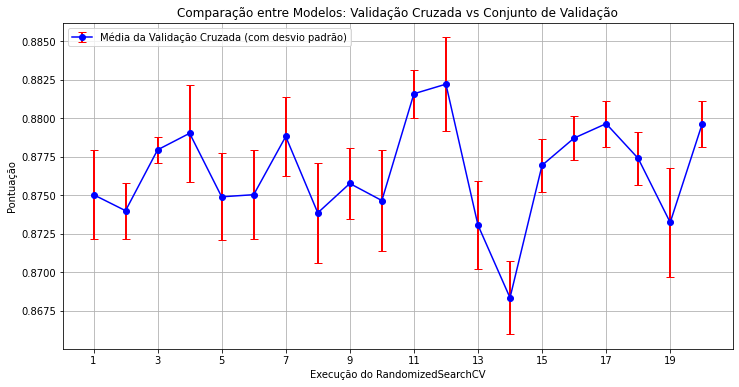

In [6]:
import matplotlib.pyplot as plt

num_interacoes = min(20, len(historico_mean_scores))

plt.figure(figsize=(12, 6))

# Linha azul: Média da validação cruzada + barras de erro (desvio padrão)
plt.errorbar(
    range(1, num_interacoes + 1), 
    historico_mean_scores[:num_interacoes], 
    yerr=historico_std_scores[:num_interacoes], 
    fmt='o-',  
    color='b', 
    ecolor='r',  
    elinewidth=2, 
    capsize=4, 
    label='Média da Validação Cruzada (com desvio padrão)'
)


plt.xlabel('Execução do RandomizedSearchCV')
plt.ylabel('Pontuação')
plt.title('Comparação entre Modelos: Validação Cruzada vs Conjunto de Validação')
plt.xticks(range(1, num_interacoes + 1, max(1, num_interacoes // 10)))  # Ajusta os ticks
plt.grid(True)
plt.legend()

plt.show()

In [7]:

parametros_knn = {
    'n_neighbors': 17,  
    'weights': 'distance',  
    'algorithm': 'auto',  
    'p': 2  
}

knn = KNeighborsClassifier(**parametros_knn)

knn.fit(X_train_subset, y_train_subset)

y_pred = knn.predict(X_test)

acuracia = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')  
precisao = precision_score(y_test, y_pred, average='macro') 
recall = recall_score(y_test, y_pred, average='macro')  

print(f"Acurácia no conjunto de teste: {acuracia:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precisao:.4f}")
print(f"Recall: {recall:.4f}")


Acurácia no conjunto de teste: 0.8837
F1 Score: 0.8200
Precision: 0.8471
Recall: 0.8002


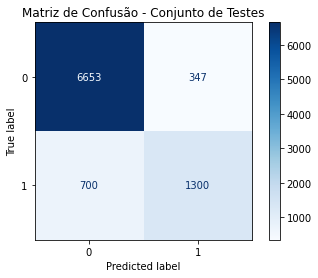

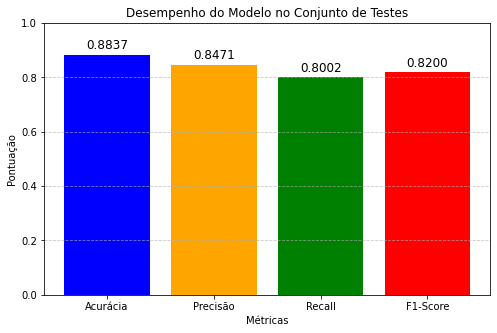

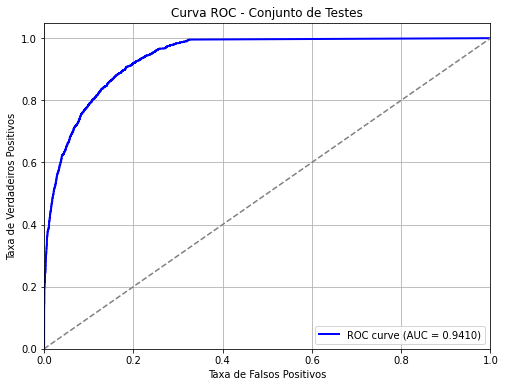

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

y_test_pred = knn.predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='macro')
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')

# MATRIZ DE CONFUSÃO
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - Conjunto de Testes")
plt.show()

# GRÁFICO DE BARRAS COM AS MÉTRICAS
metricas = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
valores = [accuracy_test, precision_test, recall_test, f1_test]

plt.figure(figsize=(8, 5))
plt.bar(metricas, valores, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Métricas')
plt.ylabel('Pontuação')
plt.ylim(0, 1)
plt.title('Desempenho do Modelo no Conjunto de Testes')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(valores):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12)

plt.show()

# CURVA ROC AUC
y_test_proba = knn.predict_proba(X_test)[:, 1]  
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Conjunto de Testes')
plt.legend(loc="lower right")
plt.grid()
plt.show()
